In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, Input, MaxPooling2D, Activation, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "../Pneumonia/chest_xray/train/"
val_dir = "../Pneumonia/chest_xray/val/"
test_dir = "../Pneumonia/chest_xray/test/"

### Creating the Datasets

In [3]:
def preprocess_image(image):
    
    """
    Preprocess the Image to be input into the model
    image: image array
    """
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image  = image * (1/255.0)
    
    return image

In [4]:
def create_dataset(directory):
    
    """
    Create dataset to pass into model
    directory: directory for image locations
    
    Returns:
    X: Images
    y: Labels
    """
    
    labels = ['NORMAL', 'PNEUMONIA']
    
    #Images and Labels
    X = []
    y = []
    
    for label in labels:
        path = directory + label
        
        for img in os.listdir(path):
            
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            image = preprocess_image(image)
            
            X.append(image)
            if label == 'NORMAL':
                y.append(0)
            else:
                y.append(1)
             
    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
X_train, y_train = create_dataset(directory=train_dir)

In [6]:
X_val, y_val = create_dataset(directory=val_dir)

In [7]:
X_test, y_test = create_dataset(directory=test_dir)

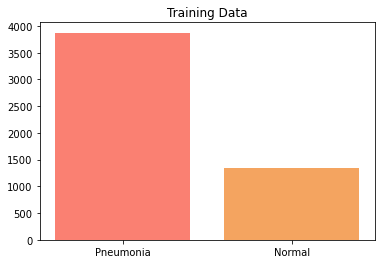

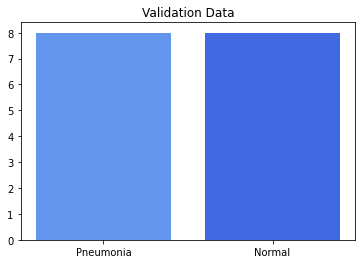

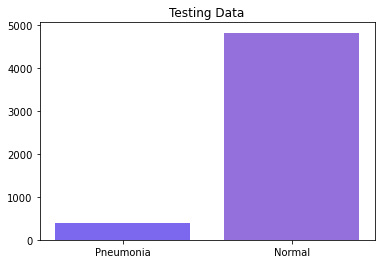

In [8]:
import seaborn as sns
plt.title("Training Data")
plt.bar(x = ["Pneumonia", "Normal"], height = [np.sum(y_train), len(y_train) - np.sum(y_train)],
        color = ['salmon', 'sandybrown'])
plt.show()

plt.title("Validation Data")
plt.bar(x = ["Pneumonia", "Normal"], height = [np.sum(y_val), len(y_val) - np.sum(y_val)], 
        color = ['cornflowerblue', 'royalblue'])
plt.show()

plt.title("Testing Data")
plt.bar(x = ["Pneumonia", "Normal"], height = [np.sum(y_test), len(y_train) - np.sum(y_test)],
        color = ['mediumslateblue', 'mediumpurple'])
plt.show()

In [9]:
from tensorflow.keras.applications import DenseNet121, ResNet50V2, InceptionV3

In [10]:
new_input = Input(shape = (224, 224, 3))
dense = DenseNet121(include_top = False, input_tensor=new_input)

In [11]:
dense.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [12]:
for layer in dense.layers[:-9]:
    layer.trainable = False

In [77]:
def dense_model(dense_net):
    
    model = tf.keras.models.Sequential()
    model.add(dense_net)
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides = (1, 1)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding = 'same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(Conv2D(32, (5, 5), strides = (2, 2)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    

    return model

In [78]:
dense_net = dense_model(dense)

In [79]:
dense_net.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adagrad(), metrics = ['accuracy'])

In [80]:
dense_net.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
batch_normalization_103 (Bat (None, 7, 7, 1024)        4096      
_________________________________________________________________
dropout_24 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 5, 5, 64)          589888    
_________________________________________________________________
batch_normalization_104 (Bat (None, 5, 5, 64)          256       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 5, 5, 32)         

In [81]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.1,
                             zoom_range=0.3, horizontal_flip=True, brightness_range=(0.5, 1.5))

In [82]:
train_generator = datagen.flow(X_train, y_train, batch_size=8)
val_generator = datagen.flow(X_val, y_val, batch_size=1)

In [30]:
history = dense_net.fit(train_generator, validation_data=val_generator, epochs = 30)

Epoch 1/25
652/652 [==============================] - 82s 126ms/step - loss: 0.3601 - accuracy: 0.8505 - val_loss: 1.1771 - val_accuracy: 0.6875
Epoch 2/25
652/652 [==============================] - 76s 116ms/step - loss: 0.2550 - accuracy: 0.8936 - val_loss: 1.7326 - val_accuracy: 0.6250
Epoch 3/25
652/652 [==============================] - 76s 117ms/step - loss: 0.2227 - accuracy: 0.9153 - val_loss: 0.8465 - val_accuracy: 0.6875
Epoch 4/25
652/652 [==============================] - 75s 115ms/step - loss: 0.2106 - accuracy: 0.9124 - val_loss: 1.4937 - val_accuracy: 0.5625
Epoch 5/25
652/652 [==============================] - 79s 120ms/step - loss: 0.1943 - accuracy: 0.9216 - val_loss: 1.4371 - val_accuracy: 0.7500
Epoch 6/25
652/652 [==============================] - 82s 125ms/step - loss: 0.1932 - accuracy: 0.9235 - val_loss: 0.8934 - val_accuracy: 0.6875
Epoch 7/25
652/652 [==============================] - 80s 123ms/step - loss: 0.1752 - accuracy: 0.9304 - val_loss: 0.9701 - val_ac

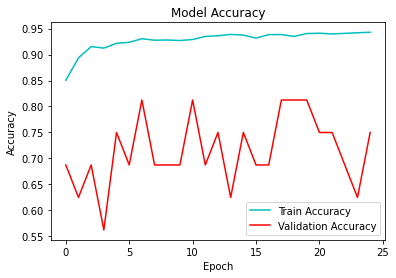

In [31]:
plt.plot(history.history['accuracy'], color = 'c')
plt.plot(history.history['val_accuracy'], color = 'r')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc = 'lower right')
plt.show()

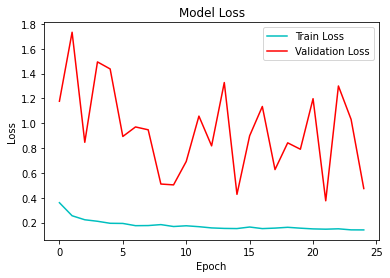

In [33]:
plt.plot(history.history['loss'], color = 'c')
plt.plot(history.history['val_loss'], color = 'r')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

In [34]:
y_preds_dense = dense_net.predict(X_test)

In [35]:
y_preds_dense

array([[0.35368374],
       [0.6586573 ],
       [0.5304951 ],
       [0.5840076 ],
       [0.4522309 ],
       [0.18466932],
       [0.45978147],
       [0.5013364 ],
       [0.5669644 ],
       [0.0900337 ],
       [0.26145986],
       [0.949838  ],
       [0.83755004],
       [0.21404813],
       [0.8865674 ],
       [0.8582822 ],
       [0.6260456 ],
       [0.5172534 ],
       [0.71152604],
       [0.5964807 ],
       [0.9170331 ],
       [0.9315976 ],
       [0.8148134 ],
       [0.91822714],
       [0.8548268 ],
       [0.8213009 ],
       [0.91232675],
       [0.71492034],
       [0.8221754 ],
       [0.86482143],
       [0.97691184],
       [0.24761407],
       [0.7973364 ],
       [0.599166  ],
       [0.64349633],
       [0.33923396],
       [0.8220179 ],
       [0.28041995],
       [0.24362151],
       [0.63795847],
       [0.5116546 ],
       [0.24781825],
       [0.67132527],
       [0.2838315 ],
       [0.44759157],
       [0.8242795 ],
       [0.4159146 ],
       [0.571

In [36]:
def threshold_accuracy(y_test, y_preds):
    
    preds = y_preds.flatten()
    low = min(preds)
    high = max(preds) 
    threholds = np.linspace(low, high, 20000)
    final_thresh = 0
    max_acc = 0
    
    for threhold in threholds:
        labels = np.array(preds >= threhold)
        accuracy = np.sum(labels == y_test)/len(y_test)
        
        if accuracy > max_acc:
            max_acc = accuracy
            final_thresh = threhold
            
    return max_acc, final_thresh 

In [37]:
accuracy, threshold = threshold_accuracy(y_test, y_preds_dense)

In [38]:
accuracy, threshold

(0.8044871794871795, 0.6303204833564117)